<a href="https://colab.research.google.com/github/Gabrielzzz7/news-appeal-analysis/blob/main/Pipeline_completo_analise_FakeNewsNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalação das bibliotecas
# NLTK (Natural Language Toolkit) --> análise linguística
# VADER --> análise de sentimentos otimizada para textos de mídias sociais
!pip install nltk vaderSentiment tqdm textstat scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency, mannwhitneyu

import nltk
import re
import textstat
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

tqdm.pandas()
nltk.download(['punkt_tab', 'stopwords', 'averaged_perceptron_tagger_eng'], quiet=True)
textstat.set_lang('en_US')

In [3]:
# Carregar os rótulos manuais

!wget -nv "https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/amostra_1_rotulada.csv"
!wget -nv "https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/amostra_2_rotulada.csv"
!wget -nv "https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/amostra_3_rotulada.csv"
!wget -nv "https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/amostra_4_rotulada.csv"
!wget -nv "https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/dados_combinados.csv"

arquivos_rotulados = [
    'amostra_1_rotulada.csv', 'amostra_2_rotulada.csv',
    'amostra_3_rotulada.csv', 'amostra_4_rotulada.csv'
]
lista_dfs_rotulados = []

print("Lendo e processando arquivos de rótulos...")
for nome_arquivo in arquivos_rotulados:
    try:
        temp_df = pd.read_csv(nome_arquivo)
    except Exception:
        try:
            temp_df = pd.read_csv(nome_arquivo, sep=';')
        except Exception as e:
            print(f"ERRO ao ler '{nome_arquivo}': {e}")
            continue
    if 'rótulo' in temp_df.columns:
        temp_df.rename(columns={'rótulo': 'apelativa'}, inplace=True)
    if 'id' in temp_df.columns and 'apelativa' in temp_df.columns:
        lista_dfs_rotulados.append(temp_df[['id', 'apelativa']])

if not lista_dfs_rotulados:
    raise ValueError("Nenhum arquivo de rótulo foi carregado com sucesso. Interrompendo.")

df_rotulos_consolidados = pd.concat(lista_dfs_rotulados, ignore_index=True)
df_rotulos_consolidados.drop_duplicates(subset='id', keep='last', inplace=True)
print(f"\nTotal de {len(df_rotulos_consolidados)} rótulos únicos consolidados.")

# Carrega o dataset principal e cria o DataFrame consolidado
!wget -O dados_combinados.csv "https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/main/dados_combinados.csv"
df_main = pd.read_csv('dados_combinados.csv')
df_consolidado = pd.merge(df_main, df_rotulos_consolidados, on='id', how='left')

# Limpeza e Mapeamento da coluna 'label'
df_consolidado.dropna(subset=['title', 'label'], inplace=True)
df_consolidado['label_str'] = df_consolidado['label'].astype(str).str.lower()
df_consolidado['label_numeric'] = df_consolidado['label_str'].map({'real': 0, 'fake': 1})
df_consolidado.dropna(subset=['label_numeric'], inplace=True) # Remove linhas onde o mapeamento falhou
df_consolidado['label_numeric'] = df_consolidado['label_numeric'].astype(int)

print("\n DataFrame Consolidado criado com sucesso! ")
df_consolidado.info()

2025-07-07 00:05:34 URL:https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/amostra_1_rotulada.csv [202732/202732] -> "amostra_1_rotulada.csv" [1]
2025-07-07 00:05:34 URL:https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/amostra_2_rotulada.csv [299231/299231] -> "amostra_2_rotulada.csv" [1]
2025-07-07 00:05:34 URL:https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/amostra_3_rotulada.csv [201469/201469] -> "amostra_3_rotulada.csv" [1]
2025-07-07 00:05:35 URL:https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/amostra_4_rotulada.csv [184178/184178] -> "amostra_4_rotulada.csv" [1]
2025-07-07 00:05:36 URL:https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/dados_combinados.csv [44454025/44454025] -> "dados_combinados.csv" [1]
Lendo e processando arquivos de rótulos...

Total de 500 rótulos únicos consolidados.
--2025-07-07 00:05:36-- 

In [4]:
# Pré-processamento e Extração de Atributos

# Stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    return " ".join([word for word in tokens if word not in stop_words])

def count_pos_tags_avancado(text):
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    superlatives = len([word for word, tag in tags if tag in ['JJS', 'RBS']])
    return superlatives

def count_all_caps(text):
    if not isinstance(text, str): return 0
    return len([word for word in text.split() if word.isupper() and len(word) > 2])

#  Dicionário de palavras de apelo em Inglês
APPEAL_WORDS_EN = ['shocking', 'unbelievable', 'secret', 'reveals', 'controversy', 'bombshell', 'alert', 'risk', 'urgent', 'exclusive', 'breaking']
def count_appeal_words(text):
    if not isinstance(text, str): return 0
    text_lower = text.lower()
    return len([word for word in APPEAL_WORDS_EN if word in text_lower])

analyzer = SentimentIntensityAnalyzer()
def get_vader_scores(text):
    return analyzer.polarity_scores(text)['compound']


# Aplicação das funções
print("Iniciando pré-processamento do texto...")
df_consolidado['title_cleaned'] = df_consolidado['title'].progress_apply(preprocess_text)
print("Pré-processamento concluído.")

print("\nIniciando extração de atributos avançados...")
df_consolidado['word_count'] = df_consolidado['title_cleaned'].apply(lambda x: len(x.split()))
df_consolidado['exclamation_count'] = df_consolidado['title'].str.count('!')
df_consolidado['question_mark_count'] = df_consolidado['title'].str.count('\?')
df_consolidado['superlatives'] = df_consolidado['title_cleaned'].progress_apply(count_pos_tags_avancado)
df_consolidado['all_caps_count'] = df_consolidado['title'].progress_apply(count_all_caps)
df_consolidado['appeal_words_count'] = df_consolidado['title'].progress_apply(count_appeal_words)
df_consolidado['sentiment_compound'] = df_consolidado['title_cleaned'].progress_apply(get_vader_scores)
df_consolidado['readability_score'] = df_consolidado['title'].progress_apply(textstat.flesch_reading_ease)
print("Extração de atributos avançados concluída.")

Iniciando pré-processamento do texto...


  0%|          | 0/23196 [00:00<?, ?it/s]

Pré-processamento concluído.

Iniciando extração de atributos avançados...


  0%|          | 0/23196 [00:00<?, ?it/s]

  0%|          | 0/23196 [00:00<?, ?it/s]

  0%|          | 0/23196 [00:00<?, ?it/s]

  0%|          | 0/23196 [00:00<?, ?it/s]

  0%|          | 0/23196 [00:00<?, ?it/s]

Extração de atributos avançados concluída.



Média das features normalizadas por 1000 palavras:
       superlatives_norm  exclamation_count_norm  question_mark_count_norm  \
label                                                                        
fake                5.34                    8.90                     16.32   
real                6.59                    6.26                      6.02   

       all_caps_count_norm  appeal_words_count_norm  
label                                                
fake                 23.95                     9.56  
real                 17.60                     6.01  

Gerando visualizações com gráficos de violino e de pontos...


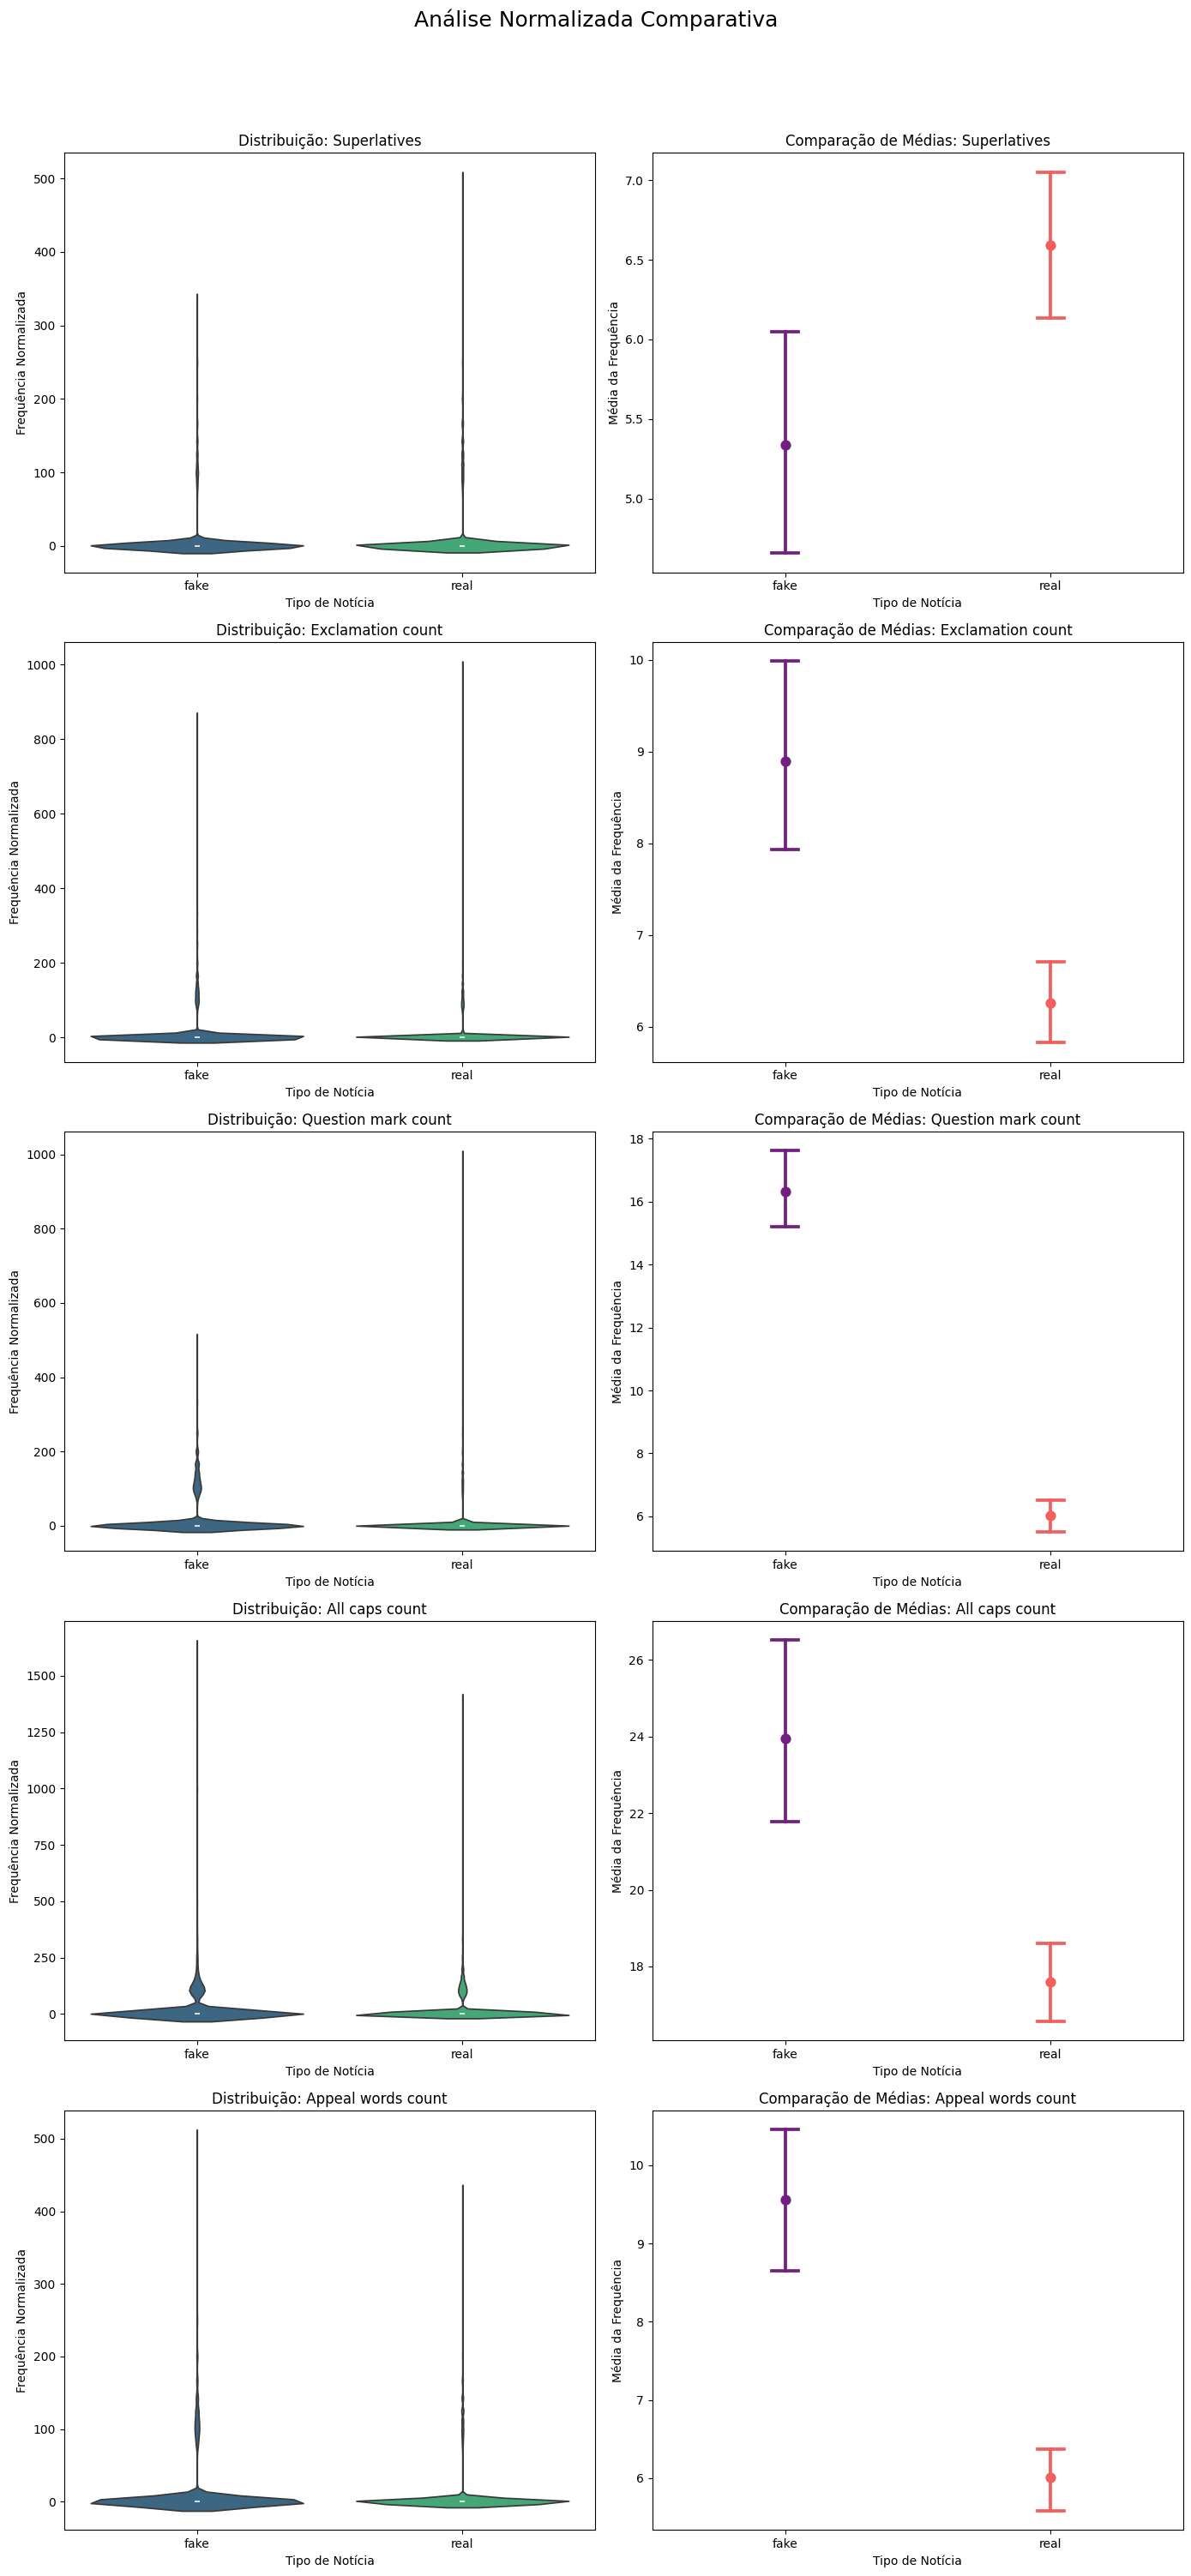


 Treinando modelo para Fake vs. Verdadeira com features avançadas 

Importância dos Atributos Avançados para Diferenciar Fake News:
               feature  importance
7    readability_score      0.4281
2   sentiment_compound      0.3201
0           word_count      0.1578
4  question_mark_count      0.0304
5       all_caps_count      0.0256
3    exclamation_count      0.0138
6   appeal_words_count      0.0133
1         superlatives      0.0109


In [5]:
# Análise Normalizada, Gráficos e Modelo para `label`

# Definição da Lista de Features
features = [
    'word_count', 'superlatives', 'sentiment_compound', 'exclamation_count',
    'question_mark_count', 'all_caps_count', 'appeal_words_count', 'readability_score'
]


# Normalização e Análise Estatística
df_analise = df_consolidado[df_consolidado['word_count'] > 0].copy()
norm_cols_data = {}
for feature in features:
    # Apenas normaliza features de contagem
    if feature not in ['word_count', 'readability_score', 'sentiment_compound']:
         col_name = f'{feature}_norm'
         df_analise[col_name] = (df_analise[feature] / df_analise['word_count']) * 1000
         norm_cols_data[col_name] = feature.replace('_', ' ').capitalize()

print("\nMédia das features normalizadas por 1000 palavras:")
norm_cols = list(norm_cols_data.keys())
print(df_analise.groupby('label')[norm_cols].mean().round(2))

# Gráficos
print("\nGerando visualizações com gráficos de violino e de pontos...")

num_features = len(norm_cols_data)
plt.figure(figsize=(14, 6 * num_features))
plt.suptitle('Análise Normalizada Comparativa', fontsize=18, y=1.0)

# Loop para criar um par de gráficos (violino e ponto) para cada feature
for i, (col, title) in enumerate(norm_cols_data.items()):
    # Gráfico de Violino (esquerda)
    ax1 = plt.subplot(num_features, 2, 2*i + 1)
    sns.violinplot(data=df_analise, x='label', y=col, hue='label', palette='viridis', legend=False, ax=ax1)
    ax1.set_title(f'Distribuição: {title}')
    ax1.set_xlabel('Tipo de Notícia')
    ax1.set_ylabel('Frequência Normalizada')

    # Gráfico de Pontos (direita)
    ax2 = plt.subplot(num_features, 2, 2*i + 2)
    sns.pointplot(data=df_analise, x='label', y=col, hue='label', palette='magma', errorbar='ci', capsize=.1, legend=False, ax=ax2)
    ax2.set_title(f'Comparação de Médias: {title}')
    ax2.set_xlabel('Tipo de Notícia')
    ax2.set_ylabel('Média da Frequência')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# Modelo de Classificação
print("\n Treinando modelo para Fake vs. Verdadeira com features avançadas ")
X = df_consolidado[features]
y = df_consolidado['label_numeric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
rf_model_label = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_label.fit(X_train, y_train)

print("\nImportância dos Atributos Avançados para Diferenciar Fake News:")
feature_importances_label = pd.DataFrame({'feature': features, 'importance': rf_model_label.feature_importances_}).sort_values('importance', ascending=False)
print(feature_importances_label.round(4))

In [6]:
print("\n Teste de Significância de Mann-Whitney U ")

# Separa os dados em dois grupos: fake e real
fake_news_data = df_analise[df_analise['label'] == 'fake']
real_news_data = df_analise[df_analise['label'] == 'real']

# Features que queremos testar
features_para_testar = ['superlatives_norm', 'sentiment_compound', 'exclamation_count', 'question_mark_count', 'all_caps_count_norm', 'appeal_words_count_norm', 'readability_score']

for feature in features_para_testar:
    # Realiza o teste
    stat, p_valor = mannwhitneyu(fake_news_data[feature], real_news_data[feature], alternative='two-sided')

    print(f"\nTeste para a feature: '{feature}'")
    print(f'P-valor: {p_valor:.4f}')

    if p_valor < 0.05:
        print(">> Conclusão: A diferença entre fake e real é ESTATISTICAMENTE SIGNIFICATIVA.")
    else:
        print(">> Conclusão: A diferença NÃO é estatisticamente significativa.")


 Teste de Significância de Mann-Whitney U 

Teste para a feature: 'superlatives_norm'
P-valor: 0.0109
>> Conclusão: A diferença entre fake e real é ESTATISTICAMENTE SIGNIFICATIVA.

Teste para a feature: 'sentiment_compound'
P-valor: 0.0000
>> Conclusão: A diferença entre fake e real é ESTATISTICAMENTE SIGNIFICATIVA.

Teste para a feature: 'exclamation_count'
P-valor: 0.0142
>> Conclusão: A diferença entre fake e real é ESTATISTICAMENTE SIGNIFICATIVA.

Teste para a feature: 'question_mark_count'
P-valor: 0.0000
>> Conclusão: A diferença entre fake e real é ESTATISTICAMENTE SIGNIFICATIVA.

Teste para a feature: 'all_caps_count_norm'
P-valor: 0.0000
>> Conclusão: A diferença entre fake e real é ESTATISTICAMENTE SIGNIFICATIVA.

Teste para a feature: 'appeal_words_count_norm'
P-valor: 0.0000
>> Conclusão: A diferença entre fake e real é ESTATISTICAMENTE SIGNIFICATIVA.

Teste para a feature: 'readability_score'
P-valor: 0.0000
>> Conclusão: A diferença entre fake e real é ESTATISTICAMENTE S

In [7]:
# Análise e Modelo para Apelo (com dados rotulados)
print("\n Análise e Modelo para Apelo ")

df_rotulados_humanos = df_consolidado[df_consolidado['apelativa'].notna()].copy()
df_rotulados_humanos['apelativa'] = df_rotulados_humanos['apelativa'].astype(int)

print(f"Total de {len(df_rotulados_humanos)} notícias com rótulos humanos para treinar o modelo de 'apelo'.")

if not df_rotulados_humanos.empty:
    X_apelativa = df_rotulados_humanos[features] # Usa a mesma lista de features avançadas
    y_apelativa = df_rotulados_humanos['apelativa']

    rf_model_apelativa = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model_apelativa.fit(X_apelativa, y_apelativa)

    print("\nImportância dos Atributos para Identificar um Título Apelativo:")
    feature_importances_apelativa = pd.DataFrame({'feature': features, 'importance': rf_model_apelativa.feature_importances_}).sort_values('importance', ascending=False)
    print(feature_importances_apelativa.round(4))
else:
    print("Nenhum dado rotulado como 'apelativa' encontrado para treinar o modelo.")


 Análise e Modelo para Apelo 
Total de 500 notícias com rótulos humanos para treinar o modelo de 'apelo'.

Importância dos Atributos para Identificar um Título Apelativo:
               feature  importance
7    readability_score      0.3739
2   sentiment_compound      0.2910
0           word_count      0.1931
4  question_mark_count      0.0519
5       all_caps_count      0.0350
6   appeal_words_count      0.0308
3    exclamation_count      0.0148
1         superlatives      0.0094



 Classificação de todo o dataset 

Análise Cruzada Final: Fake/True vs. Apelativa/Não Apelativa
apelativa_final      0     1
label                       
fake              3113  2642
real             10994  6447

Análise Percentual:
apelativa_final      0      1
label                        
fake             54.09  45.91
real             63.04  36.96


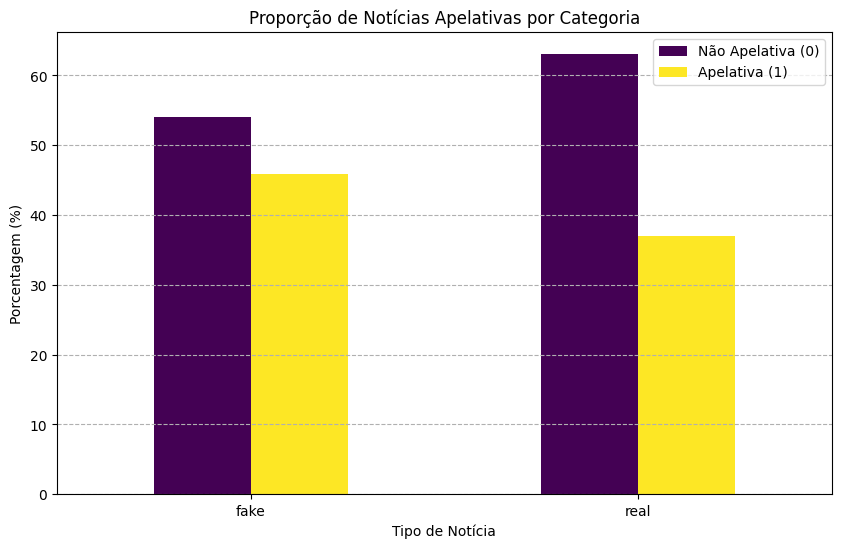


Teste Qui-Quadrado: p-valor = 0.0000
>> A associação entre o tipo de notícia e o apelo é ESTATISTICAMENTE SIGNIFICATIVA.


In [8]:
# Classificação de todo o dataset e análise

if 'rf_model_apelativa' in locals():
    print("\n Classificação de todo o dataset ")

    # 1. Prever o apelo para TODO o dataset usando o modelo treinado
    X_completo = df_consolidado[features]
    predictions = rf_model_apelativa.predict(X_completo)

    # 2. Criar a coluna final de apelo
    #    Começamos com os rótulos humanos como base (coluna 'apelativa')
    df_consolidado['apelativa_final'] = df_consolidado['apelativa']

    #    Agora, preenchemos os valores vazios (NaN) com as previsões do modelo.
    df_consolidado['apelativa_final'] = df_consolidado['apelativa_final'].fillna(pd.Series(predictions, index=df_consolidado.index))

    # Garante que a coluna final seja do tipo inteiro
    df_consolidado['apelativa_final'] = df_consolidado['apelativa_final'].astype(int)

    # 3. Análise Cruzada e Teste Estatístico
    analise_cruzada = pd.crosstab(df_consolidado['label'], df_consolidado['apelativa_final'])
    print("\nAnálise Cruzada Final: Fake/True vs. Apelativa/Não Apelativa")
    print(analise_cruzada)

    # Análise Percentual
    porcentagem = analise_cruzada.div(analise_cruzada.sum(axis=1), axis=0) * 100
    print("\nAnálise Percentual:")
    print(porcentagem.round(2))

    # Gráfico de Barras
    porcentagem.plot(kind='bar', figsize=(10, 6), rot=0, colormap='viridis')
    plt.title('Proporção de Notícias Apelativas por Categoria')
    plt.ylabel('Porcentagem (%)')
    plt.xlabel('Tipo de Notícia')
    plt.legend(['Não Apelativa (0)', 'Apelativa (1)'], loc='upper right')
    plt.grid(axis='y', linestyle='--')
    plt.show()

    # Teste Qui-Quadrado
    chi2, p_valor, dof, expected = chi2_contingency(analise_cruzada)
    print(f"\nTeste Qui-Quadrado: p-valor = {p_valor:.4f}")
    if p_valor <= 0.05:
        print(">> A associação entre o tipo de notícia e o apelo é ESTATISTICAMENTE SIGNIFICATIVA.")
    else:
        print(">> A associação entre o tipo de notícia e o apelo NÃO é estatisticamente significativa.")
else:
    print("\nO modelo de apelo não foi treinado. Análise final não pode ser executada.")